In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from pathlib import Path
import copy
from functools import partial

import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

In [3]:
params = {}

In [4]:
params['paths'] = {}
## Directory to save results files into
params['paths']['dir_save'] = r'/media/rich/bigSSD/analysis_data/BMI/day0_stuff/mouse_0403L/'

## Directory with F.npy, stat.npy etc.
params['paths']['dir_s2p_outer'] = r'/media/rich/bigSSD/data_raw/BMI/mouse_0403L/'

In [5]:
%load_ext autoreload
%autoreload 2
import bnpm
import roicat

In [ ]:
use_multiple_sessions = True
path_roicat_classification = r'/media/rich/bigSSD/analysis_data/BMI/day0_stuff/mouse_0403L/mouse_0403L_20230702_and_20230703.ROICaT.classification_drawn.results.pkl'

if use_multiple_sessions:
    path_roicat_tracking   = r'/media/rich/bigSSD/analysis_data/BMI/day0_stuff/mouse_0403R/mouse_0403R_20230702_and_20230703.ROICaT.tracking.results.pkl'
    
    results_roicat_tracking       = bnpm.file_helpers.pickle_load(str(Path(path_roicat_tracking).resolve()))
    results_roicat_classification = bnpm.file_helpers.pickle_load(str(Path(path_roicat_classification).resolve()))    
    
    
    ucids_iscell_fullMatch = roicat.util.discard_UCIDs_with_fewer_matches(
        ucids=roicat.util.mask_UCIDs_with_iscell(
            ucids=results_roicat_tracking['clusters']['labels_bySession'],
            iscell=results_roicat_classification['preds'],
        ),
        n_sesh_thresh='all',
    )
    iscell_roicatClassification_trackingMatch = [np.array(u) >= 0 for u in ucids_iscell_fullMatch]
else:
    iscell_roicatClassification_trackingMatch = bnpm.file_helpers.pickle_load(str(Path(path_roicat_classification).resolve()))['preds']

In [167]:
filepaths_F = bnpm.path_helpers.find_paths(
    dir_outer=params['paths']['dir_s2p_outer'],
    reMatch='F.npy',
    depth=3,
)
print(f'filepaths with F.npy:')
[print(f'{f}') for f in filepaths_F]

dirs_s2p = [str(Path(p).parent) for p in filepaths_F]

filepaths with F.npy:
/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/20230424/F.npy
/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/20230425/F.npy


In [168]:
## == IMPORT DATA ==
outs = [bnpm.ca2p_preprocessing.import_s2p(d) for d in dirs_s2p]

## Concatenate sessions into a single combined session
F_all, Fneu_all, iscell_s2p_all, ops_all, spks_s2p_all, stat_all = ([o[ii] for o in outs] for ii in range(len(outs[0])))

<IPython.core.display.Javascript object>


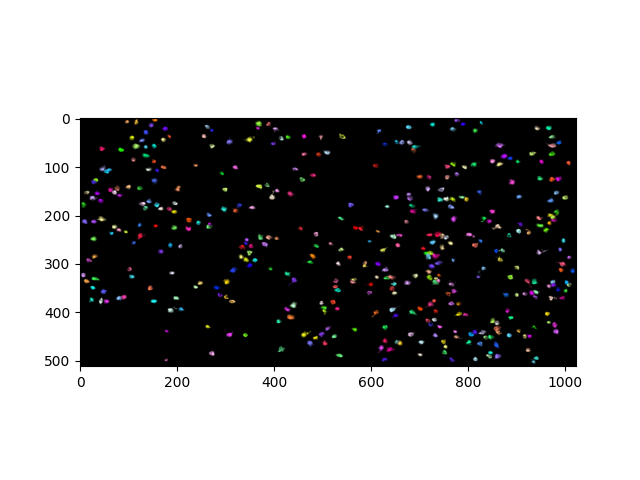

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [170]:
if use_multiple_sessions:
    FOVs_colored = roicat.visualization.compute_colored_FOV(
        spatialFootprints=results_roicat_tracking['ROIs']['ROIs_aligned'], 
        FOV_height=results_roicat_tracking['ROIs']['frame_height'], 
        FOV_width=results_roicat_tracking['ROIs']['frame_width'], 
    #     labels=results_tracking['UCIDs_bySession'], 
        labels=ucids_iscell_fullMatch,
    )

    %matplotlib notebook

    roicat.visualization.display_toggle_image_stack(FOVs_colored)

In [171]:
if use_multiple_sessions:
    F_matched, Fneu_matched = (roicat.util.match_arrays_with_ucids(f, ucids_iscell_fullMatch) for f in (F_all, Fneu_all))
else:
    F_matched, Fneu_matched = F_all, Fneu_all

In [172]:
def plot_paired_trace_reduction(traces, reduction=np.nanmean):
    """
    args:
        traces (ndarray):
            shape(n_sessions, n_neurons, n_timepoints)
        reduction (function):
            function that accepts 'axis' argument
    """
    red_traces = [reduction(t, axis=1) for t in traces]
    red_traces_max = np.nanmax(np.nanmax(red_traces))

    plt.figure()
    plt.scatter(red_traces[0], red_traces[1], alpha=0.1)
    plt.xlim([0, red_traces_max])
    plt.ylim([0, red_traces_max])
    plt.plot([0, red_traces_max], [0, red_traces_max], 'k')
    plt.xlabel(f'traces day 0: {reduction}')
    plt.ylabel(f'traces day 1: {reduction}')
    

<IPython.core.display.Javascript object>


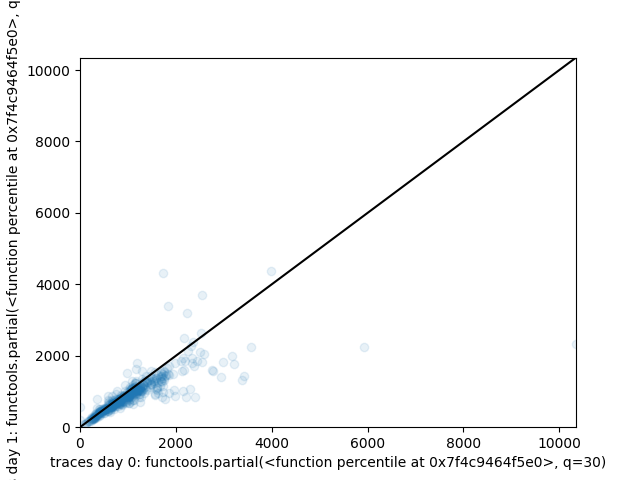

<IPython.core.display.Javascript object>


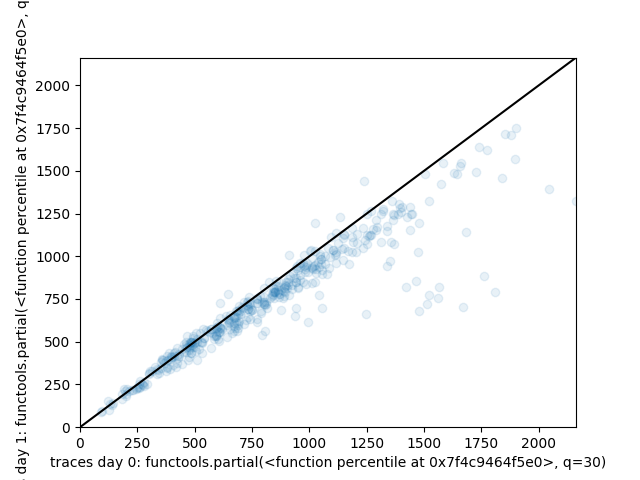

In [173]:
if use_multiple_sessions:
    plot_paired_trace_reduction(
        F_matched,
        reduction=partial(np.percentile, q=30)
    )
    plot_paired_trace_reduction(
        Fneu_matched, 
        reduction=partial(np.percentile, q=30)
    )

In [174]:
n_frames, n_rois, n_sessions = sum([f.shape[1] for f in F_matched]), F_matched[0].shape[0], len(F_matched)
Fs = ops_all[0]['fs']

In [175]:
# # Oopsie!
# # Mouse g2FB: delete 43000 - 50000 frames
# F_toUse = np.delete(F_toUse, range(43000,50000), axis=1)
# Fneu_toUse = np.delete(Fneu_toUse, range(43000,50000), axis=1)

In [176]:
percentile_baseline = 30
neuropil_fraction=0.7

outs = [bnpm.ca2p_preprocessing.make_dFoF(
    F=f,
    Fneu=fneu,
    neuropil_fraction=neuropil_fraction,
    percentile_baseline=percentile_baseline,
    rolling_percentile_window=None,
    multicore_pref=True,
    verbose=True
) for f, fneu in zip(F_matched, Fneu_matched)]

dFoF_matched , dF_matched , F_neuSub_matched , F_baseline_matched = ([outs[i_sesh][i_out] for i_sesh in range(n_sessions)] for i_out in range(len(outs[0])))

dFoF_params = {
    "channelOffset_correction": 0,
    "percentile_baseline": percentile_baseline,
    "neuropil_fraction": neuropil_fraction,
}

Calculated dFoF. Total elapsed time: 0.21 seconds
Calculated dFoF. Total elapsed time: 0.2 seconds


In [177]:
win_rolling_percentile = 15*60*30

outs = [bnpm.ca2p_preprocessing.make_dFoF(
    F=f,
    Fneu=fneu,
    neuropil_fraction=neuropil_fraction,
    percentile_baseline=percentile_baseline,
    rolling_percentile_window=win_rolling_percentile,
    roll_centered=True,
    roll_stride=1,
    roll_interpolation='linear',
    multicore_pref=True,
    verbose=True
) for f, fneu in zip(F_matched, Fneu_matched)]

dFoF_roll_matched , dF_roll_matched , F_roll_neuSub_matched , F_roll_baseline_matched = ([outs[i_sesh][i_out] for i_sesh in range(n_sessions)] for i_out in range(len(outs[0])))

dFoF_params = {
    "channelOffset_correction": 0,
    "percentile_baseline": percentile_baseline,
    "neuropil_fraction": neuropil_fraction,
}

100%|███████████████████████████████████████████| 35/35 [00:05<00:00,  6.96it/s]


Calculated dFoF. Total elapsed time: 15.99 seconds


100%|███████████████████████████████████████████| 35/35 [00:04<00:00,  7.63it/s]


Calculated dFoF. Total elapsed time: 16.47 seconds


<IPython.core.display.Javascript object>


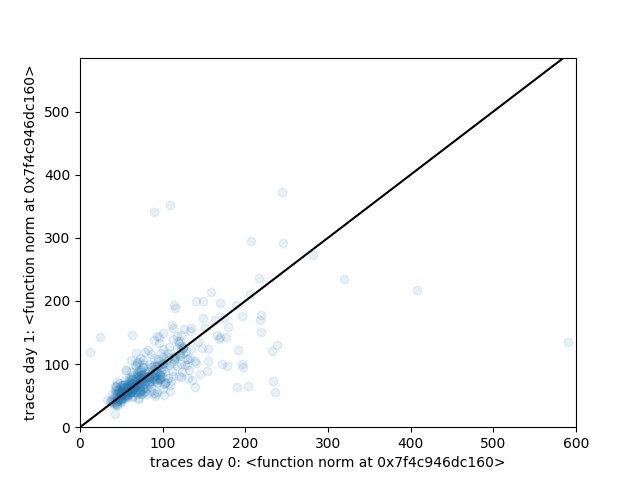

In [178]:
if use_multiple_sessions:
    plot_paired_trace_reduction(
        dFoF_roll_matched, 
        reduction=np.linalg.norm,
    )

<IPython.core.display.Javascript object>


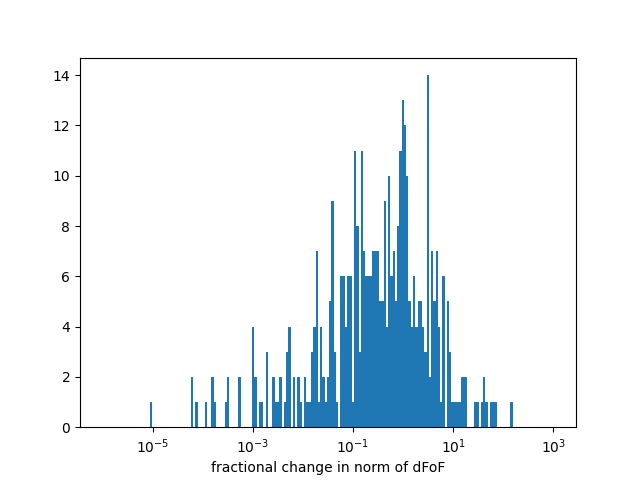

In [179]:
if use_multiple_sessions:
    norms = np.stack([np.linalg.norm(dfof, axis=1) for dfof in dFoF_roll_matched])
    # folds = (norms[0] - norms[1]) / ((norms[0] + norms[1])/2)
    fanos = np.var(norms, axis=0) / np.mean(norms, axis=0)

    plt.figure()
    plt.hist(fanos, bins=bnpm.math_functions.bounded_logspace(1e-6, 1000, 200));
    plt.xscale('log')
    plt.xlabel('fractional change in norm of dFoF')

<IPython.core.display.Javascript object>


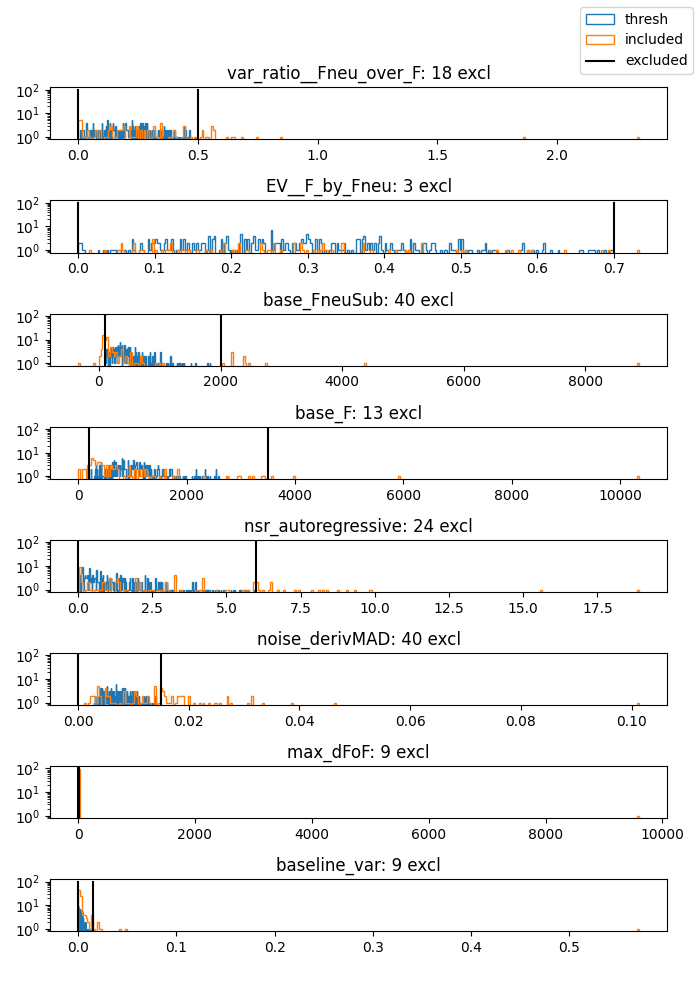

<IPython.core.display.Javascript object>


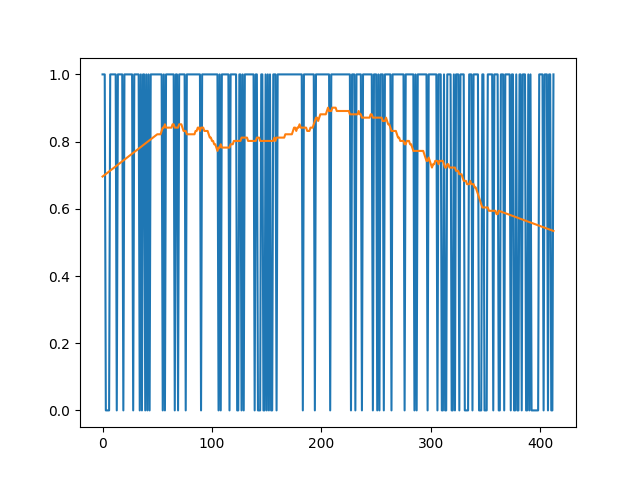

ROIs excluded: 95 / 413
ROIs included: 318 / 413


<IPython.core.display.Javascript object>


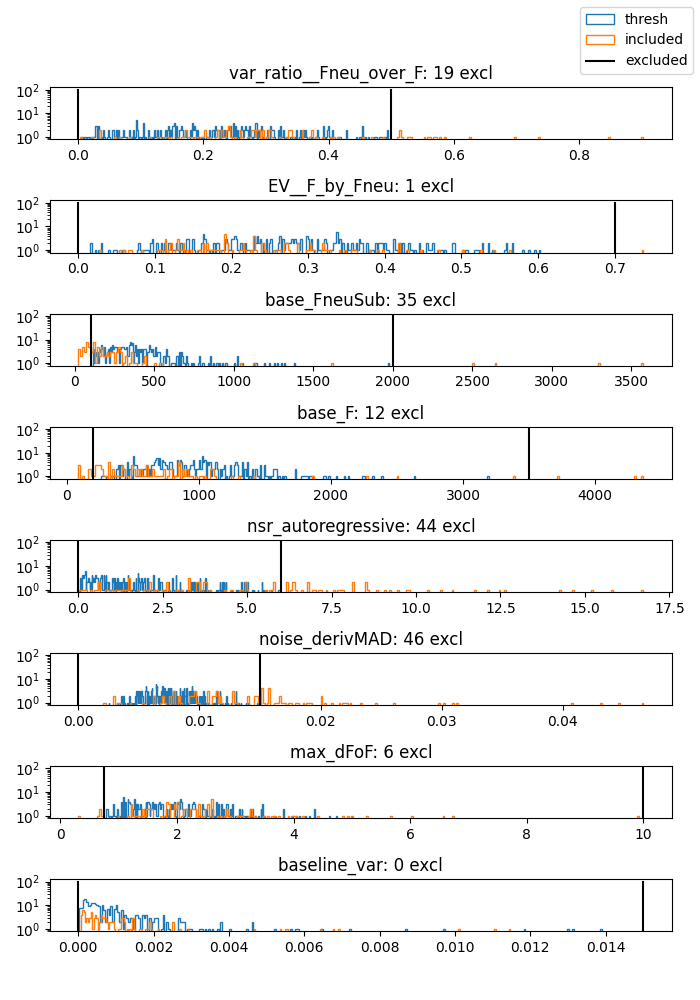

<IPython.core.display.Javascript object>


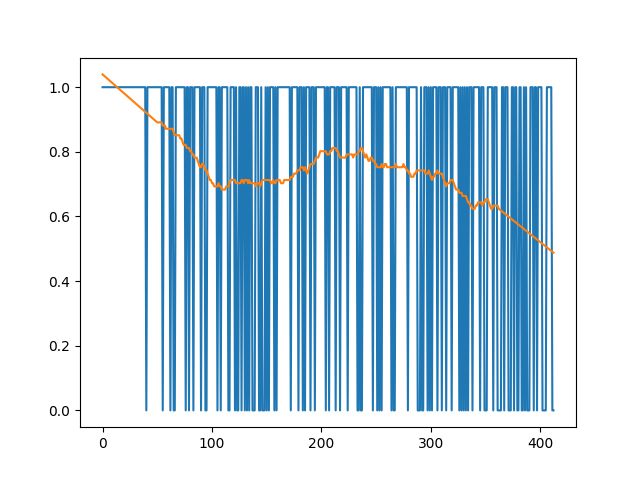

ROIs excluded: 105 / 413
ROIs included: 308 / 413


In [214]:
%matplotlib notebook

thresh = {
    'var_ratio__Fneu_over_F': (0, 0.5),
    'EV__F_by_Fneu': (0, 0.7),
    'base_FneuSub': (100, 2000),
    'base_F': (200, 3500),
    'nsr_autoregressive': (0, 6),
    'noise_derivMAD': (0, 0.015),
    'max_dFoF': (0.75, 10),
    'baseline_var': (0, 0.015),
    
#     'var_ratio__Fneu_over_F': (0, np.inf),
#     'EV__F_by_Fneu': (0, 0.9),
#     'base_FneuSub': (75, 2000),
#     'base_F': (200, 3500),
#     'nsr_autoregressive': (0, 25),
#     'noise_derivMAD': (0, 0.1),
#     'max_dFoF': (0, 10),
#     'baseline_var': (0, 0.1),

}
# thresh = {
#     'var_ratio__Fneu_over_F': np.inf,
#     'EV__F_by_Fneu': np.inf,
#     'base_FneuSub': -np.inf,
#     'base_F': -np.inf,
#     'nsr_autoregressive': np.inf,
#     'noise_derivMAD': np.inf,
#     'max_dFoF': np.inf,
#     'baseline_var': np.inf,
# }
    
outs = [bnpm.ca2p_preprocessing.trace_quality_metrics(
    F=f,
    Fneu=fneu,
    dFoF=dfof,
    F_neuSub=fneusub,
    F_baseline_roll=fbs,

#     F=f[iscell_roicatClassification_trackingMatch[0].astype(np.bool_)],
#     Fneu=fneu[iscell_roicatClassification_trackingMatch[0].astype(np.bool_)],
#     dFoF=dfof[iscell_roicatClassification_trackingMatch[0].astype(np.bool_)],
#     F_neuSub=fneusub[iscell_roicatClassification_trackingMatch[0].astype(np.bool_)],
#     F_baseline_roll=fbs[iscell_roicatClassification_trackingMatch[0].astype(np.bool_)],

    percentile_baseline=percentile_baseline,
    Fs=Fs,
    plot_pref=True,
    thresh=thresh,
    device='cpu',
) for f, fneu, dfof, fneusub, fbs in zip(F_matched, Fneu_matched, dFoF_roll_matched, F_neuSub_matched, F_roll_baseline_matched)]

tqm, iscell_tqm = ([outs[ii][jj] for ii in range(len(outs))] for jj in range(len(outs[0])))

idxROI_tqm_toInclude = [np.where(ic)[0] for ic in iscell_tqm]
idxROI_tqm_toExclude = [np.where(~ic)[0] for ic in iscell_tqm]

In [215]:
if use_multiple_sessions:
    iscell_conj = [np.array(ic, dtype=bool) for ic in iscell_roicatClassification_trackingMatch]
    for i_sesh in range(len(iscell_conj)):
        iscell_conj[i_sesh][np.where(iscell_conj[i_sesh])[0][~iscell_tqm[i_sesh]]] = False

else:
    iscell_conj = [(ic_rc_tm * ic_tqm).astype(np.bool_) for ic_rc_tm, ic_tqm in zip(iscell_roicatClassification_trackingMatch, iscell_tqm)]

In [216]:
import rastermap

rmap = rastermap.Rastermap(n_components=1)
rmap.fit(dFoF_roll_matched[0][iscell_tqm[0]])

nmin 200
0.0500643253326416
7.035749673843384
7.363300085067749
7.364523649215698
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.01s     0        0.0775      2
0.10s    10        0.2562      4
0.17s    20        0.2850      8
0.23s    30        0.3309      18
0.29s    40        0.3821      28
0.38s    50        0.4259      38
0.46s    60        0.4261      38
0.53s   final      0.4261
0.53s upsampled    0.4261


<IPython.core.display.Javascript object>


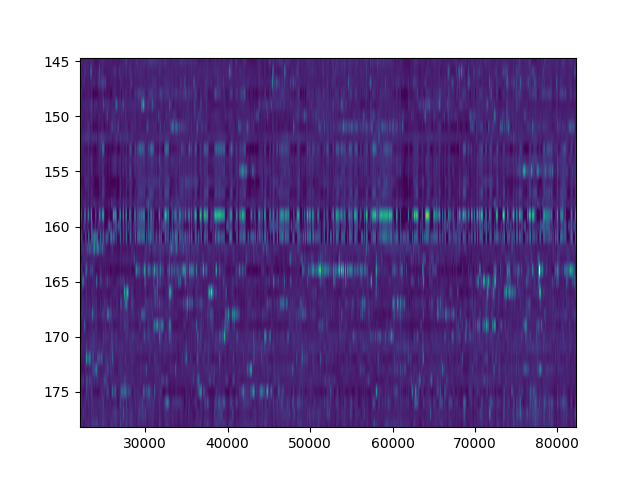

In [217]:
plt.figure()
plt.imshow(dFoF_roll_matched[0][iscell_tqm[0]][rmap.isort], aspect='auto', vmin=-0.1, vmax=2)

In [219]:
if use_multiple_sessions:
    ucids_iscell_fullMatch_tqm = roicat.util.discard_UCIDs_with_fewer_matches(
        ucids=roicat.util.mask_UCIDs_with_iscell(
            ucids=results_roicat_tracking['UCIDs_bySession'],
            iscell=iscell_conj,
        ),
        n_sesh_thresh='all',
    )

ROICaT WARNING: lolod is a list of np.ndarray of numbers (int or float). Converting to np.ndarray.
ROICaT WARNING: lolod is a list of np.ndarray of numbers (int or float). Converting to np.ndarray.
ROICaT WARNING: lolod is a list of np.ndarray of numbers (int or float). Converting to np.ndarray.
INFO: 74.84% of UCIDs in first session appear in at least 2 sessions.


In [220]:
(np.array(ucids_iscell_fullMatch_tqm[0]) >= 0).sum()

238

<IPython.core.display.Javascript object>


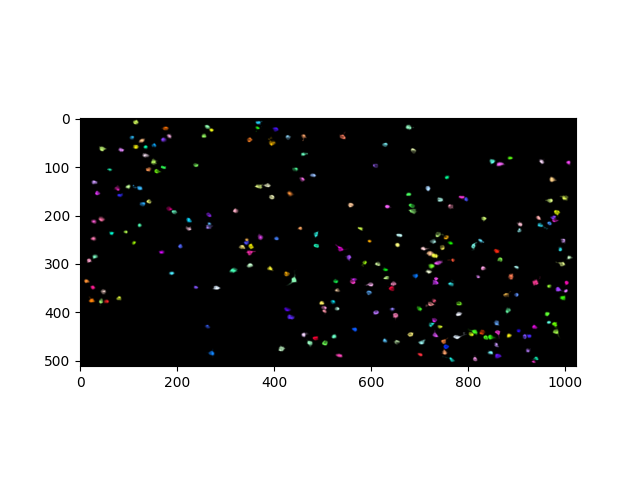

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [221]:
if use_multiple_sessions:
    FOVs_colored = roicat.visualization.compute_colored_FOV(
        spatialFootprints=results_roicat_tracking['ROIs']['ROIs_aligned'], 
        FOV_height=results_roicat_tracking['ROIs']['frame_height'], 
        FOV_width=results_roicat_tracking['ROIs']['frame_width'], 
    #     labels=results_tracking['UCIDs_bySession'], 
        labels=ucids_iscell_fullMatch_tqm,
    )

    %matplotlib notebook

    roicat.visualization.display_toggle_image_stack(FOVs_colored)

<IPython.core.display.Javascript object>


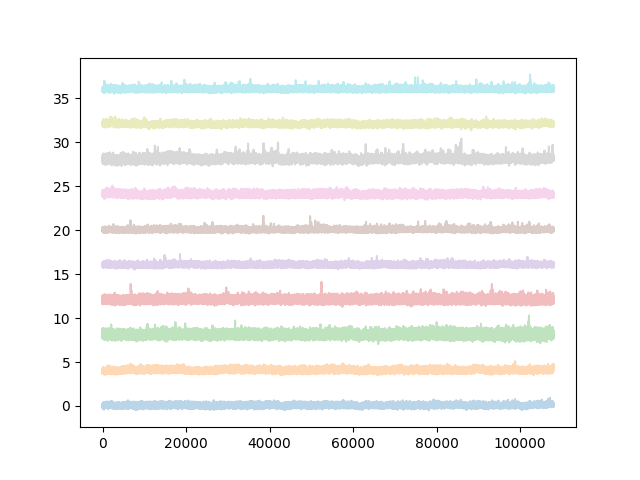

IndexError: tuple index out of range

In [222]:
plt.figure()
[plt.plot(dFoF_roll_matched[ii][np.where(iscell_conj[ii][iscell_roicatClassification_trackingMatch[ii]])[ii][-10:]].T + np.arange(10)*4, alpha=0.3) for ii in range(len(dFoF_roll_matched))];


<IPython.core.display.Javascript object>


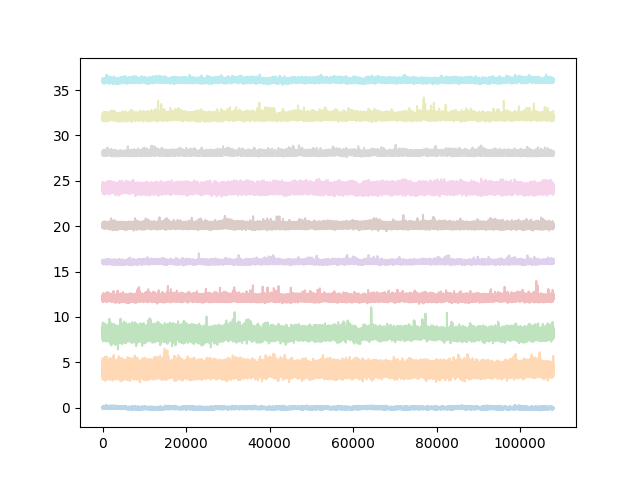

IndexError: tuple index out of range

In [197]:
plt.figure()
[plt.plot(dFoF_roll_matched[ii][np.where(~iscell_conj[ii][iscell_roicatClassification_trackingMatch[ii]])[ii][-10:]].T + np.arange(10)*4, alpha=0.3) for ii in range(len(dFoF_roll_matched))];


In [223]:
params['paths']

{'dir_save': '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/',
 'dir_s2p_outer': '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/'}

In [224]:
len(iscell_conj[0])

2576

In [225]:
len(ucids_iscell_fullMatch_tqm[0])

2576

In [226]:
bnpm.file_helpers.pickle_save(
    obj={
        "tqm": tqm,
        "iscell_tqm": iscell_tqm,
        "iscell_classifier_matching_tqm": iscell_conj,
        "dFoF_params": dFoF_params
    },
    filepath=str(Path(params['paths']['dir_save']).resolve() / 'trace_quality.pkl')
)

bnpm.file_helpers.pickle_save(
    obj={
        "iscell_classifier_matching_tqm": iscell_conj,
        "UCIDs_classifier_matching_tqm": ucids_iscell_fullMatch_tqm if use_multiple_sessions else None,
    },
    filepath=str(Path(params['paths']['dir_save']).resolve() / 'iscell_classifier_matching_tqm.pkl'),
)